In [1]:
import xarray as xr

nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc') # Copernicus (0.1°x0.1°)

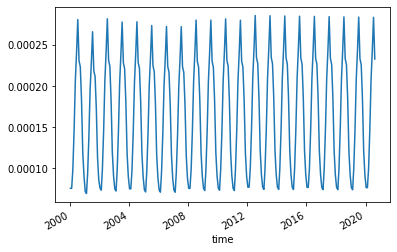

In [3]:
from utils import utils
import matplotlib.pyplot as plt

nh3 = utils.xarray2pandas(nh3_nc.agl, 6, 17)
nh3.plot()
plt.show()

Distribuzione di probabilità

In [160]:
import numpy as np
from scipy.stats import norm

def plot_distributions(ts, title):

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    #axs[0].set_xlim((min(ts)/2, max(ts)*1.1))

    result = axs[0].hist(ts, bins=20)

    fig.suptitle(title)

    mean = np.mean(ts)
    sigma = np.sqrt(np.var(ts))
    x = np.linspace(min(ts), max(ts), 100)
    dx = result[1][1] - result[1][0]
    scale = len(ts)*dx
    
    axs[0].plot(x, norm.pdf(x, mean, sigma)*scale)

    axs[1] = ts.plot(kind='kde')

    plt.show()

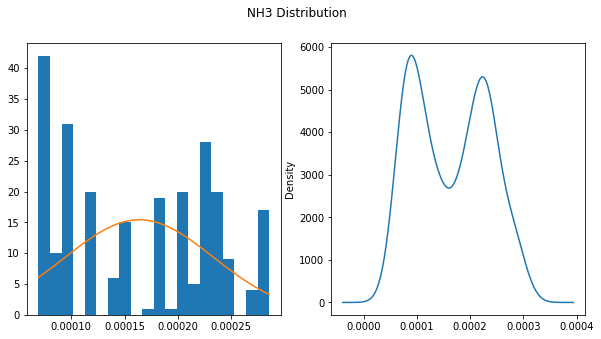

In [161]:
plot_distributions(nh3, 'NH3 Distribution')

H0 : dati proventienti da distribuzione gaussiana

In [38]:
from statsmodels.stats.stattools import jarque_bera

jb, pvalue, sk, k = jarque_bera(nh3)

print('test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

test: not normally distributed, pvalue: 2.2545662531377113e-05


H0 : dati provenienti da distribuzione gaussiana

In [181]:
from statsmodels.stats.diagnostic import lilliefors

ksstat, pvalue = lilliefors(nh3)

print('test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

test: not normally distributed, pvalue: 0.0009999999999998899


Normalizing the time series

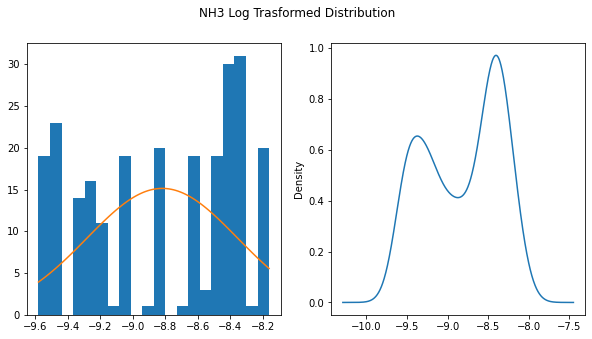

jarque bera test: not normally distributed, pvalue: 4.98265777910253e-06
lilliefors test: not normally distributed, pvalue: 0.0009999999999998899


In [180]:
# Log Transformation

nh3log = nh3.apply(np.log)

plot_distributions(nh3log, 'NH3 Log Trasformed Distribution')

jb, pvalue, sk, k = jarque_bera(nh3log)
print('jarque bera test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

ksstat, pvalue = lilliefors(nh3log)
print('lilliefors test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

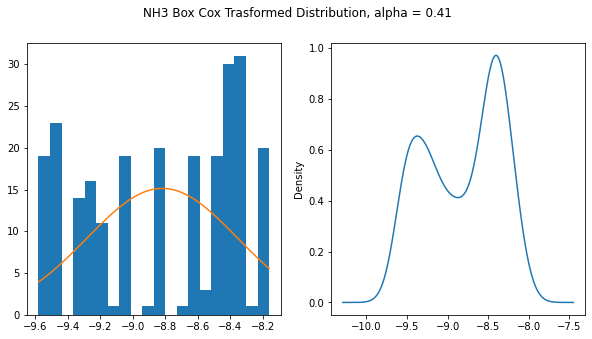

jarque bera test: not normally distributed, pvalue: 8.623960063282488e-06
lilliefors test: not normally distributed, pvalue: 0.0009999999999998899


In [179]:
# Box Cox Transformation

from scipy.stats import boxcox

nh3bc, alpha = boxcox(nh3)
nh3bc = pd.Series(nh3bc)

plot_distributions(nh3log, 'NH3 Box Cox Trasformed Distribution, alpha = {}'.format(round(alpha,2)))

jb, pvalue, sk, k = jarque_bera(nh3bc)
print('jarque bera test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

ksstat, pvalue = lilliefors(nh3bc)
print('lilliefors test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

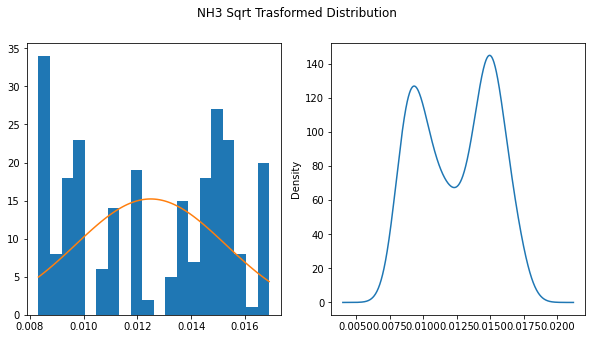

jarque bera test: not normally distributed, pvalue: 9.868200266020414e-06
lilliefors test: not normally distributed, pvalue: 0.0009999999999998899


In [178]:
nh3sqrt = nh3.apply(np.sqrt)

plot_distributions(nh3sqrt, 'NH3 Sqrt Trasformed Distribution')

jb, pvalue, sk, k = jarque_bera(nh3sqrt)
print('jarque bera test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

ksstat, pvalue = lilliefors(nh3sqrt)
print('lilliefors test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

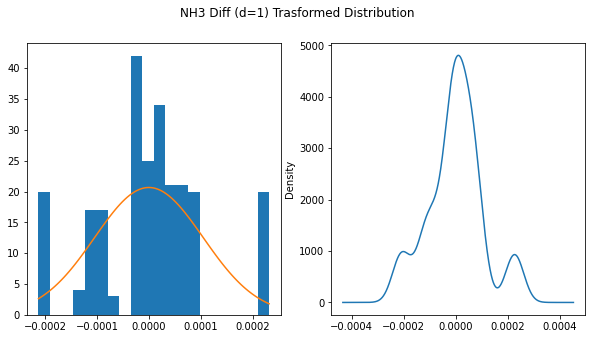

jarque bera test: normally distributed, pvalue: 0.44760024559125167
lilliefors test: not normally distributed, pvalue: 9.269987589269126e-14


In [177]:
from statsmodels.tsa.statespace.tools import diff

nh3diff = diff(nh3, 4)

plot_distributions(nh3diff, 'NH3 Diff (d=1) Trasformed Distribution')

jb, pvalue, sk, k = jarque_bera(nh3diff)
print('jarque bera test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

ksstat, pvalue = lilliefors(nh3diff)
print('lilliefors test: {}, pvalue: {}'.format('normally distributed' if pvalue > 0.05 else 'not normally distributed', pvalue))

<AxesSubplot:xlabel='time'>

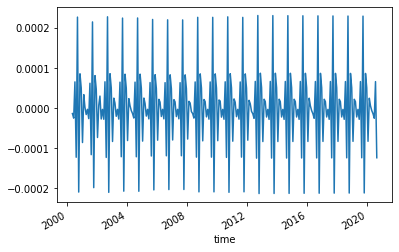

In [182]:
nh3diff.plot()

H0 : coefficienti = 1 -> radici unitarie

In [41]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(nh3)

print('test: {}, pvalue: {}'.format('stationary' if pvalue > 0.05 else 'not stationary', pvalue))

test: stationary, pvalue: 0.32997165346008384


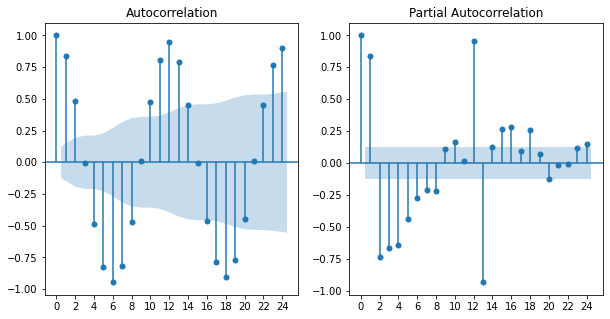

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plot_acf(nh3, ax=axs[0])
axs[0].set_xticks(range(0,25,2))
plot_pacf(nh3, method='ols', ax=axs[1])
axs[1].set_xticks(range(0,25,2))

plt.show()

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

df = pd.DataFrame(data=nh3.values, index=pd.date_range(start=nh3.index[0], periods=248, freq='M'), columns=['nh3'])
decomposition = seasonal_decompose(df, model='additive')

Additive Decomposition: y ~ trend + seasonality + residuals
Naive Decomposition

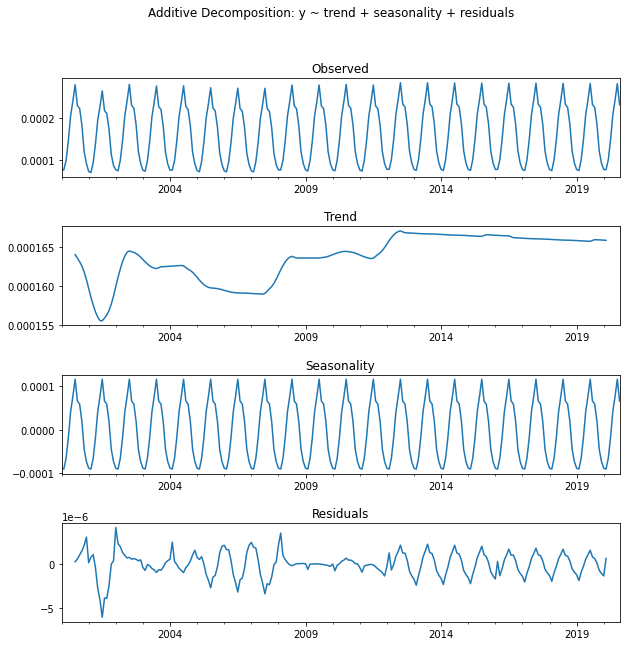

In [66]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10,10))
fig.suptitle('Additive Decomposition: y ~ trend + seasonality + residuals')
fig.subplots_adjust(hspace = 0.5)

axs[0].set_title('Observed')
decomposition.observed.plot(ax=axs[0])

axs[1].set_title('Trend')
decomposition.trend.plot(ax=axs[1])

axs[2].set_title('Seasonality')
decomposition.seasonal.plot(ax=axs[2])

axs[3].set_title('Residuals')
decomposition.resid.plot(ax=axs[3])

plt.show()

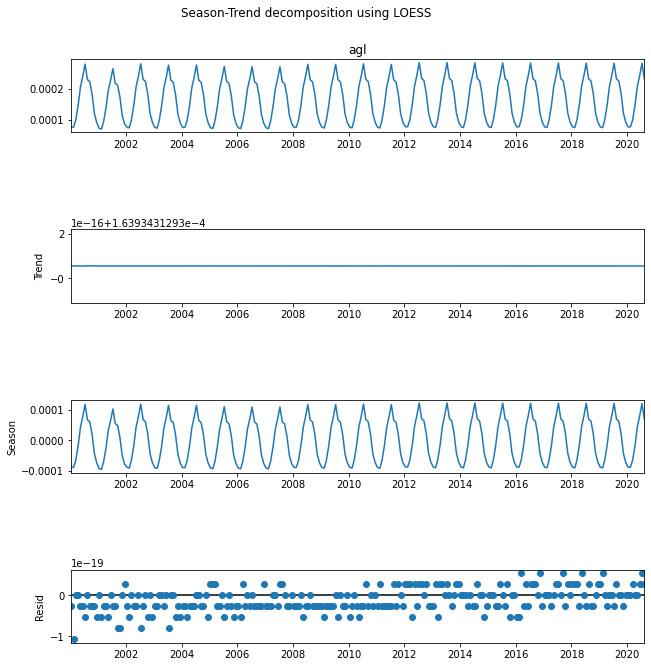

In [78]:
from statsmodels.tsa.seasonal import STL


fig = STL(nh3, period=248).fit().plot()
fig.set_size_inches(10, 10)
fig.suptitle('Season-Trend decomposition using LOESS')

plt.show()